In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# tullock alpha < 1

In [151]:
b1, b2, v1, v2 = sp.symbols('b_1 b_2 v_1 v_2')

a = 1/2

x1 = b1**a / (b1**a + b2**a)
x2 = b2**a / (b1**a + b2**a)

u1 = v1 * x1 - b1
u2 = v2 * x2 - b2
u2

b_2**0.5*v_2/(b_1**0.5 + b_2**0.5) - b_2

In [152]:
part1 = sp.simplify(sp.diff(u1, b1))
part2 = sp.simplify(sp.diff(u2, b2))
part2

0.5*b_1**0.5*v_2/(b_2**0.5*(b_1**0.5 + b_2**0.5)**2) - 1

In [177]:
func1 = sp.lambdify([b1, b2], part1.evalf(subs={v1:11.}))
func2 = sp.lambdify([b1, b2], part2.evalf(subs={v2:1.}))

In [178]:
def eqs(p):
    b1, b2 = p
    return [func1(b1, b2), func2(b1, b2)]

sol = fsolve(eqs, (0.49, 0.12))
sol, sol[0]/sol[1], sum(sol)

(array([0.97897236, 0.08899749]), 10.99999999989627, 1.0679698490599445)

# monotonicity 
 
- we noticed that in the gamma-k construction, there was some monotonicity
  - payments monotone decreasing in k
  - welfare cost monotone increasing in k
- intuitively it feels like neither of these hold more generally, would be good to show that.

In [ ]:
# payments. there must be a new player that has a "high enough" true cost to make us pay more

In [2]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [233]:
bids  = getEquilBids([4,2], a=3)
allos = getAllos(bids, 3)
bids, allos, np.dot(bids, allos)

(array([9.66287915, 8.8109329 ]),
 array([0.43121518, 0.56878482]),
 9.178305051291098)

In [274]:
bids = getEquilBids([4,2,20], a=3, guess=[9,8,30])
allos = getAllos(bids, 3)
bids, allos, np.dot(bids, allos)

(array([ 9.44715449,  8.56976702, 30.19759448]),
 array([0.42189055, 0.56519173, 0.01291772]),
 9.219310678501467)

In [285]:
# welfare. there may be a situation where adding a second "low cost" bidder actually improves welfare loss

In [282]:
costs = [4,2]
bids  = getEquilBids(costs, a=3)
allos = getAllos(bids, 3)
bids, allos, np.dot(costs, allos)

(array([9.66287915, 8.8109329 ]),
 array([0.43121518, 0.56878482]),
 2.862430353259135)

In [305]:
costs = [4,2,2]
bids  = getEquilBids(costs, a=3)
allos = getAllos(bids, 3)
bids, allos, np.dot(costs, allos)

(array([6.60620491, 4.73000037, 4.73000037]),
 array([0.15506709, 0.42246646, 0.42246646]),
 2.3101341775411135)

# welfare degredation in n

- we want to make statements like, given an alpha, the welfare degrades slowly in n even in the worst case
- consider the setting where c_1=1 and we add more players. the welfare decreases as you allocate to more people. 
- the best case is that the welfare loss is ... because you allocate 1-1/a to c_1=1 and 1/a to a player with value C. then your welfare is 1-1/a+C/a = (c+a-1)/a

In [19]:
(300000+4-1)/4

75000.75

In [16]:
a     = 4
costs = [1,300000]
bids  = getEquilBids(costs, a=a, guess=[10, 30])
allos = getAllos(bids, a=a)
loss  = np.dot(costs, allos)
lossB = np.dot(costs, [1-1/a, 1/a])
bids, allos, loss, lossB, (loss-lossB)/loss

(array([341926.55853692, 450000.21932736]),
 array([0.74999927, 0.25000073]),
 75000.9693499513,
 75000.75,
 2.92462821741219e-06)

In [ ]:
# alpha = 3, show welfare loss as fn of N for various c

In [77]:
a     = 3
ns    = np.arange(2, 25)

a3c2res  = []
for n in tqdm(ns):
    costs = [1]
    costs.extend([2]*n)
    guess = [1]
    guess.extend([3]*n)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    a3c2res.append(np.dot(costs, allos))
a3c2res = np.array(a3c2res)
a3c2res.shape

100%|██████████| 23/23 [00:04<00:00,  4.97it/s]


(23,)

In [80]:
a3c16res  = []
for n in tqdm(ns):
    costs = [1]
    costs.extend([16]*n)
    guess = [1]
    guess.extend([13]*n)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
#     print(bids, allos)
#     print(costs, guess)
#     break
    a3c16res.append(np.dot(costs, allos))
a3c16res = np.array(a3c16res)
a3c16res.shape

100%|██████████| 23/23 [00:05<00:00,  4.57it/s]


(23,)

In [102]:
a3c128res  = []
for n in tqdm(ns):
    costs = [1]
    costs.extend([128]*n)
    guess = [200]
    guess.extend([500]*n)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
#     print(bids, allos)
#     print(costs, guess)
#     break
    a3c128res.append(np.dot(costs, allos))
a3c128res = np.array(a3c128res)
a3c128res.shape

100%|██████████| 23/23 [00:04<00:00,  4.71it/s]


(23,)

In [145]:
a3c2res_honest  = []
a3c16res_honest  = []
a3c128res_honest  = []
for n in tqdm(ns):
    costs = [1.]
    costs.extend([2.]*n)
    allos = getAllos(np.array(costs), a=a)
    a3c2res_honest.append(np.dot(costs, allos))
    costs = [1.]
    costs.extend([16.]*n)
    allos = getAllos(np.array(costs), a=a)
    a3c16res_honest.append(np.dot(costs, allos))
    costs = [1.]
    costs.extend([128.]*n)
    allos = getAllos(np.array(costs), a=a)
    a3c128res_honest.append(np.dot(costs, allos))
a3c2res_honest = np.array(a3c2res_honest)
a3c16res_honest = np.array(a3c16res_honest)
a3c128res_honest = np.array(a3c128res_honest)
a3c2res_honest.shape

100%|██████████| 23/23 [00:00<00:00, 2446.84it/s]


(23,)

In [118]:
a3c2pdiff = 100*(a3c2res-((2+a-1)/a))/((2+a-1)/a)
a3c16pdiff = 100*(a3c16res-((16+a-1)/a))/((16+a-1)/a)
a3c128pdiff = 100*(a3c128res-((128+a-1)/a))/((128+a-1)/a)
a3c128pdiff

array([0.72889764, 0.87005104, 0.975692  , 1.06231362, 1.13674689,
       1.20257152, 1.26192913, 1.31621615, 1.36640024, 1.41318304,
       1.45709154, 1.49853289, 1.53782897, 1.57523928, 1.61097631,
       1.64521663, 1.67810873, 1.70977883, 1.74033518, 1.76987147,
       1.79846936, 1.8262005 , 1.8531282 ])

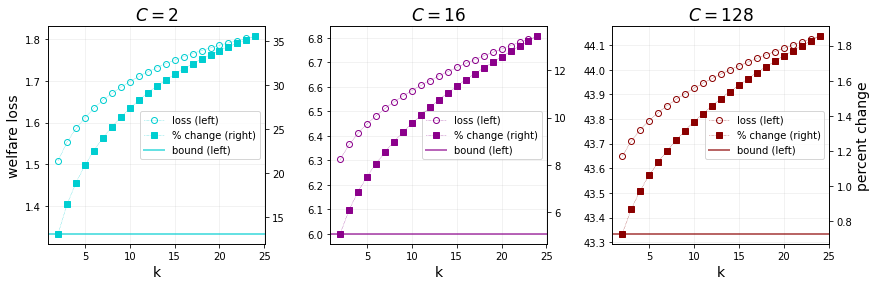

In [157]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

data = [
    (a3c2res, a3c2pdiff, a3c2res_honest, 'darkturquoise', (2+a-1)/a, r'$C=2$'),
    (a3c16res, a3c16pdiff, a3c16res_honest, 'darkmagenta', (16+a-1)/a, r'$C=16$'),
    (a3c128res, a3c128pdiff, a3c128res_honest, 'darkred', (128+a-1)/a, r'$C=128$')
]

for i, (res, pdiff, honest, color, hline_value, title) in enumerate(data):
    line1, = axarr[i].plot(ns, res, color=color, linewidth=0.5, label='loss (left)',
                           linestyle='dotted', marker='o', fillstyle='none')
    line2 = axarr[i].axhline(hline_value, color=color, label='bound (left)', alpha=0.6, linewidth=2)
    
    twinx = axarr[i].twinx()
    line3, = twinx.plot(ns, pdiff, color=color, linewidth=0.5, label='% change (right)',
                        linestyle='dotted', marker='s', fillstyle='full')
#     line4, = axarr[i].plot(ns, honest, color=color, linewidth=0.5, label='honest loss (left axis)',
#                            linestyle='-.', marker='*', fillstyle='none')

    lines = [line1, line3, line2]
    labels = [line.get_label() for line in lines]
    axarr[i].legend(lines, labels)
    axarr[i].set_title(title, size=17)

for ax in axarr:
    ax.set_xlabel('k', size=14)
    ax.grid(alpha=0.2)

axarr[0].set_ylabel('welfare loss', size=14)
twinx.set_ylabel('percent change', size=14)

f.subplots_adjust(wspace=0.3)
# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# counter example for adding a max-coster maximally degrading welfare 

- not finding one, interesting

In [201]:
costs = [1]
guess = [200]

costs.extend([128]*1)
guess.extend([500]*1)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)

print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 128]
bids=[204.19102779 256.63306468]
allos=[0.66502617 0.33497383]
w. loss=43.54167586667451

costs=[1, 128]; w. loss=43.54167586667451


In [202]:
costs = [1]
guess = [200]

costs.extend([128]*1)
guess.extend([500]*1)

costs.append(128)
guess.append(500)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)
print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 128, 128]
bids=[135.02747054 213.54609094 213.54609094]
allos=[0.66417961 0.16791019 0.16791019]
w. loss=43.64918897930342

costs=[1, 128, 128]; w. loss=43.64918897930342


In [204]:
costs = [1]
guess = [170]

costs.extend([128]*1)
guess.extend([200]*1)

costs.append(80)
guess.append(100)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)
print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 128, 80]
bids=[103.38458282 201.87396796 143.6156503 ]
allos=[0.66341097 0.08910643 0.24748261]
w. loss=31.867641994840255

costs=[1, 128, 80]; w. loss=31.867641994840255


In [220]:
otherCosts

array([  1,   8,  15,  22,  29,  36,  43,  50,  57,  64,  71,  78,  85,
        92,  99, 106, 113, 120, 127])

In [237]:
otherCosts = np.arange(1, 129, 3)
wWOther   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([128]*1)
    guess.extend([oc*2]*1)

    costs.append(oc)
    guess.append(oc*1.5)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther.append(np.dot(costs, allos))
len(wWOther)

43

In [236]:
otherCosts = np.arange(1, 129, 3)
wWOther_512   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([512]*1)
    guess.extend([oc*4]*1)

    costs.append(oc)
    guess.append(oc*1.5)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther_512.append(np.dot(costs, allos))
len(wWOther_512)

43

In [245]:
otherCosts = np.arange(1, 129, 3)
wWOther_64   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([64]*1)
    guess.extend([oc*1.5]*1)

    costs.append(oc)
    guess.append(oc*1.5)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther_64.append(np.dot(costs, allos))
len(wWOther_64)

43

In [246]:
otherCosts = np.arange(1, 129, 3)
wWOther_32   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([32]*1)
    guess.extend([oc*1.3]*1)

    costs.append(oc)
    guess.append(oc*1.4)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther_32.append(np.dot(costs, allos))
len(wWOther_32)

43

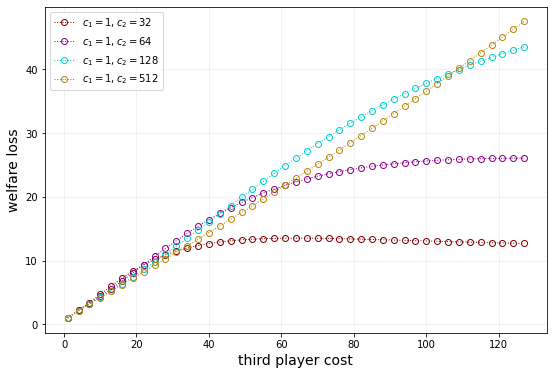

In [253]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(otherCosts, wWOther_32, color='maroon', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=32$')
ax.plot(otherCosts, wWOther_64, color='darkmagenta', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=64$')
ax.plot(otherCosts, wWOther, color='darkturquoise', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=128$')
ax.plot(otherCosts, wWOther_512, color='darkgoldenrod', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=512$')


ax.set_xlabel('third player cost', size=14)
ax.set_ylabel('welfare loss', size=14)
ax.legend()
ax.grid(alpha=0.2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [254]:
# higher cost
costs = [1]
guess = [200]

costs.extend([1024]*1)
guess.extend([500]*1)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)

print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 1024]
bids=[1626.49913864 2048.63034814]
allos=[0.6664616 0.3335384]
w. loss=342.2097817140307

costs=[1, 1024]; w. loss=342.2097817140307


In [274]:
costs = [1]
guess = [700]

costs.extend([1024]*1)
guess.extend([1200]*1)

costs.append(400)
guess.append(1000)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)
print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 1024, 400]
bids=[ 584.21583915 1564.1207904   762.84037349]
allos=[0.66609512 0.03470926 0.29919562]
w. loss=155.88662491746624

costs=[1, 1024, 400]; w. loss=155.88662491746624


In [268]:
costs = [1]
guess = [600]

costs.extend([1024]*1)
guess.extend([1200]*1)

costs.append(1024)
guess.append(1200)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)
print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 1024, 1024]
bids=[1075.76628198 1706.87845797 1706.87845797]
allos=[0.66635652 0.16682174 0.16682174]
w. loss=342.3172782823776

costs=[1, 1024, 1024]; w. loss=342.3172782823776


# different alphas welfare degredation

In [ ]:
# alpha = 3, show welfare loss as fn of N for various c

In [398]:
alphas = [3,4,5,6,7,8,9,10]
loAnz  = [2.0, 2.0, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
ns     = np.arange(2, 25)

c2res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([2]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c2res.append(temp)
c2res = np.array(c2res)
c2res.shape

0 3


100%|██████████| 23/23 [00:06<00:00,  3.38it/s]


1 4


100%|██████████| 23/23 [00:06<00:00,  3.50it/s]


2 5


100%|██████████| 23/23 [00:06<00:00,  3.47it/s]


3 6


100%|██████████| 23/23 [00:06<00:00,  3.36it/s]


4 7


100%|██████████| 23/23 [00:06<00:00,  3.46it/s]


5 8


100%|██████████| 23/23 [00:06<00:00,  3.48it/s]


6 9


100%|██████████| 23/23 [00:06<00:00,  3.52it/s]


7 10


100%|██████████| 23/23 [00:07<00:00,  3.21it/s]


(8, 23)

In [452]:
alphas = [3,4,5,6,7,8,9,10]
loAnz  = [2.0, 8.0, 8.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [16., 17., 17., 3.0, 3.0, 3.0, 3.0, 3.0]
ns     = np.arange(2, 25)

c16res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([16]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c16res.append(temp)
c16res = np.array(c16res)
c16res.shape

0 3


100%|██████████| 23/23 [00:07<00:00,  3.11it/s]


1 4


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


2 5


100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


3 6


100%|██████████| 23/23 [00:06<00:00,  3.37it/s]


4 7


100%|██████████| 23/23 [00:06<00:00,  3.41it/s]


5 8


100%|██████████| 23/23 [00:06<00:00,  3.35it/s]


6 9


100%|██████████| 23/23 [00:07<00:00,  3.23it/s]


7 10


100%|██████████| 23/23 [00:07<00:00,  3.11it/s]


(8, 23)

In [490]:
alphas = [3,4,5,6,7,8,9,10]
loAnz  = [40.0, 40.0, 60.0, 60.0, 80.0, 80.0, 80.0, 80.0]
hiAnz  = [150., 150., 150., 150., 150., 150., 150., 150.]
ns     = np.arange(2, 25)

c128res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([128]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c128res.append(temp)
c128res = np.array(c128res)
c128res.shape

0 3


100%|██████████| 23/23 [00:07<00:00,  3.28it/s]


1 4


100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


2 5


100%|██████████| 23/23 [00:07<00:00,  3.06it/s]


3 6


100%|██████████| 23/23 [00:12<00:00,  1.89it/s]


4 7


100%|██████████| 23/23 [00:07<00:00,  2.99it/s]


5 8


100%|██████████| 23/23 [00:07<00:00,  3.08it/s]


6 9


100%|██████████| 23/23 [00:07<00:00,  3.25it/s]


7 10


100%|██████████| 23/23 [00:07<00:00,  3.20it/s]


(8, 23)

In [488]:
alpha    = 9
customHi = 150.
customLo = 80.
ns       = np.arange(2, 25)
custom   = []
for n in tqdm(ns):
    costs = [1]
    guess = [customLo]

    costs.extend([128]*n)
    guess.extend([customHi]*n)

    bids  = getEquilBids(costs, a=alpha, guess=guess)
    allos = getAllos(bids, a=alpha)
    print(bids, allos)
#     break

    custom.append(np.dot(costs, allos))
custom = np.array(custom)
custom.shape

 17%|█▋        | 4/23 [00:00<00:01, 14.60it/s]

[106.7382437  145.07743378 145.07743378] [0.88783808 0.05608096 0.05608096]
[101.77864287 144.70285817 144.70285817 144.70285817] [0.88778636 0.03740455 0.03740455 0.03740455]
[ 98.45741182 144.52159762 144.52159762 144.52159762 144.52159762] [0.88774879 0.0280628  0.0280628  0.0280628  0.0280628 ]
[ 95.97843318 144.4146879  144.41468782 144.41468786 144.41468787
 144.41468786] [0.88771903 0.02245619 0.02245619 0.02245619 0.02245619 0.02245619]


 26%|██▌       | 6/23 [00:00<00:01, 10.65it/s]

[ 94.01033221 144.34416434 144.34416434 144.34416435 144.34416434
 144.34416434 144.34416434] [0.88769428 0.01871762 0.01871762 0.01871762 0.01871762 0.01871762
 0.01871762]
[ 92.38401686 144.294151   144.29415099 144.29415099 144.29415098
 144.29415099 144.29415099 144.29415099] [0.88767302 0.01604671 0.01604671 0.01604671 0.01604671 0.01604671
 0.01604671 0.01604671]


 35%|███▍      | 8/23 [00:00<00:01,  8.33it/s]

[ 91.00180393 144.25683536 144.25683536 144.25683536 144.25683536
 144.25683536 144.25683536 144.25683537 144.25683536] [0.88765435 0.01404321 0.01404321 0.01404321 0.01404321 0.01404321
 0.01404321 0.01404321 0.01404321]
[ 89.80229053 144.22792594 144.22792595 144.22792595 144.22792595
 144.22792595 144.22792595 144.22792595 144.22792595 144.22792595] [0.88763767 0.0124847  0.0124847  0.0124847  0.0124847  0.0124847
 0.0124847  0.0124847  0.0124847  0.0124847 ]


 39%|███▉      | 9/23 [00:01<00:01,  7.37it/s]

[ 88.74443193 144.20486941 144.20486941 144.20486941 144.2048694
 144.2048694  144.2048694  144.2048694  144.2048694  144.2048694
 144.2048694 ] [0.88762259 0.01123774 0.01123774 0.01123774 0.01123774 0.01123774
 0.01123774 0.01123774 0.01123774 0.01123774 0.01123774]


 43%|████▎     | 10/23 [00:01<00:02,  6.48it/s]

[ 87.79947489 144.18605146 144.18605147 144.18605145 144.18605146
 144.18605146 144.18605145 144.18605146 144.18605145 144.18605145
 144.18605145 144.18605144] [0.8876088  0.01021738 0.01021738 0.01021738 0.01021738 0.01021738
 0.01021738 0.01021738 0.01021738 0.01021738 0.01021738 0.01021738]


 48%|████▊     | 11/23 [00:01<00:02,  5.55it/s]

[ 86.94651785 144.17040119 144.17040155 144.1704016  144.17040162
 144.17040165 144.17040152 144.17040151 144.17040152 144.17040154
 144.17040152 144.17040151 144.17040152] [0.8875961  0.00936699 0.00936699 0.00936699 0.00936699 0.00936699
 0.00936699 0.00936699 0.00936699 0.00936699 0.00936699 0.00936699
 0.00936699]


 52%|█████▏    | 12/23 [00:01<00:02,  4.91it/s]

[ 86.16990485 144.15718164 144.15718156 144.15718159 144.15718161
 144.15718162 144.15718162 144.1571816  144.15718162 144.1571816
 144.1571816  144.1571816  144.1571816  144.1571816 ] [0.88758431 0.00864736 0.00864736 0.00864736 0.00864736 0.00864736
 0.00864736 0.00864736 0.00864736 0.00864736 0.00864736 0.00864736
 0.00864736 0.00864736]


 57%|█████▋    | 13/23 [00:02<00:02,  4.26it/s]

[ 85.45761502 144.14586641 144.14586641 144.14586641 144.14586641
 144.14586641 144.14586641 144.14586641 144.14586641 144.14586641
 144.14586641 144.14586641 144.14586641 144.14586641 144.14586641] [0.8875733  0.00803048 0.00803048 0.00803048 0.00803048 0.00803048
 0.00803048 0.00803048 0.00803048 0.00803048 0.00803048 0.00803048
 0.00803048 0.00803048 0.00803048]


 61%|██████    | 14/23 [00:02<00:02,  3.81it/s]

[ 84.8002243  144.13607188 144.13607188 144.13607188 144.13607189
 144.13607188 144.13607188 144.13607188 144.13607188 144.13607188
 144.13607188 144.13607188 144.13607188 144.13607188 144.13607188
 144.13607188] [0.88756298 0.0074958  0.0074958  0.0074958  0.0074958  0.0074958
 0.0074958  0.0074958  0.0074958  0.0074958  0.0074958  0.0074958
 0.0074958  0.0074958  0.0074958  0.0074958 ]


 65%|██████▌   | 15/23 [00:02<00:02,  3.36it/s]

[ 84.19021201 144.12751073 144.12751073 144.12751073 144.12751073
 144.12751073 144.12751073 144.12751073 144.12751073 144.12751073
 144.12751073 144.12751073 144.12751073 144.12751073 144.12751073
 144.12751073 144.12751073] [0.88755326 0.00702792 0.00702792 0.00702792 0.00702792 0.00702792
 0.00702792 0.00702792 0.00702792 0.00702792 0.00702792 0.00702792
 0.00702792 0.00702792 0.00702792 0.00702792 0.00702792]


 70%|██████▉   | 16/23 [00:03<00:02,  3.02it/s]

[ 83.6214837  144.11996375 144.11996375 144.11996375 144.11996375
 144.11996375 144.11996375 144.11996375 144.11996375 144.11996375
 144.11996375 144.11996375 144.11996375 144.11996375 144.11996375
 144.11996375 144.11996375 144.11996375] [0.88754407 0.00661505 0.00661505 0.00661505 0.00661505 0.00661505
 0.00661505 0.00661505 0.00661505 0.00661505 0.00661505 0.00661505
 0.00661505 0.00661505 0.00661505 0.00661505 0.00661505 0.00661505]


 74%|███████▍  | 17/23 [00:03<00:02,  2.64it/s]

[ 83.08903415 144.11326074 144.11326074 144.11326074 144.11326074
 144.11326074 144.11326074 144.11326074 144.11326074 144.11326074
 144.11326074 144.11326074 144.11326074 144.11326074 144.11326074
 144.11326074 144.11326074 144.11326074 144.11326074] [0.88753534 0.00624804 0.00624804 0.00624804 0.00624804 0.00624804
 0.00624804 0.00624804 0.00624804 0.00624804 0.00624804 0.00624804
 0.00624804 0.00624804 0.00624804 0.00624804 0.00624804 0.00624804
 0.00624804]


 78%|███████▊  | 18/23 [00:04<00:02,  2.35it/s]

[ 82.58870412 144.10726768 144.10726768 144.10726768 144.10726768
 144.10726768 144.10726768 144.10726768 144.10726768 144.10726768
 144.10726768 144.10726768 144.10726768 144.10726768 144.10726768
 144.10726768 144.10726768 144.10726768 144.10726768 144.10726768] [0.88752704 0.00591963 0.00591963 0.00591963 0.00591963 0.00591963
 0.00591963 0.00591963 0.00591963 0.00591963 0.00591963 0.00591963
 0.00591963 0.00591963 0.00591963 0.00591963 0.00591963 0.00591963
 0.00591963 0.00591963]


 83%|████████▎ | 19/23 [00:04<00:01,  2.17it/s]

[ 82.11700095 144.10187737 144.10187737 144.10187737 144.10187737
 144.10187737 144.10187737 144.10187737 144.10187737 144.10187737
 144.10187737 144.10187737 144.10187737 144.10187737 144.10187737
 144.10187737 144.10187737 144.10187737 144.10187737 144.10187737
 144.10187737] [0.88751913 0.00562404 0.00562404 0.00562404 0.00562404 0.00562404
 0.00562404 0.00562404 0.00562404 0.00562404 0.00562404 0.00562404
 0.00562404 0.00562404 0.00562404 0.00562404 0.00562404 0.00562404
 0.00562404 0.00562404 0.00562404]


 87%|████████▋ | 20/23 [00:05<00:01,  2.05it/s]

[ 81.67096443 144.09700323 144.09700323 144.09700323 144.09700323
 144.09700323 144.09700323 144.09700323 144.09700323 144.09700323
 144.09700323 144.09700323 144.09700323 144.09700323 144.09700323
 144.09700323 144.09700323 144.09700323 144.09700323 144.09700323
 144.09700323 144.09700323] [0.88751155 0.00535659 0.00535659 0.00535659 0.00535659 0.00535659
 0.00535659 0.00535659 0.00535659 0.00535659 0.00535659 0.00535659
 0.00535659 0.00535659 0.00535659 0.00535659 0.00535659 0.00535659
 0.00535659 0.00535659 0.00535659 0.00535659]


 91%|█████████▏| 21/23 [00:05<00:01,  1.91it/s]

[ 81.24806444 144.09257449 144.09257449 144.09257449 144.09257449
 144.09257449 144.09257449 144.09257449 144.09257449 144.09257449
 144.09257449 144.09257449 144.09257449 144.09257449 144.09257449
 144.09257449 144.09257449 144.09257449 144.09257449 144.09257449
 144.09257449 144.09257449 144.09257449] [0.88750429 0.00511344 0.00511344 0.00511344 0.00511344 0.00511344
 0.00511344 0.00511344 0.00511344 0.00511344 0.00511344 0.00511344
 0.00511344 0.00511344 0.00511344 0.00511344 0.00511344 0.00511344
 0.00511344 0.00511344 0.00511344 0.00511344 0.00511344]


 96%|█████████▌| 22/23 [00:06<00:00,  1.77it/s]

[ 80.84612209 144.08853276 144.08853276 144.08853276 144.08853276
 144.08853276 144.08853276 144.08853276 144.08853276 144.08853276
 144.08853276 144.08853276 144.08853276 144.08853276 144.08853276
 144.08853276 144.08853276 144.08853276 144.08853276 144.08853276
 144.08853276 144.08853276 144.08853276 144.08853276] [0.88749732 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142
 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142
 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142
 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142 0.00489142]


100%|██████████| 23/23 [00:07<00:00,  3.14it/s]

[ 80.463248   144.08482942 144.08482942 144.08482942 144.08482942
 144.08482942 144.08482942 144.08482942 144.08482942 144.08482942
 144.08482942 144.08482942 144.08482942 144.08482942 144.08482942
 144.08482942 144.08482942 144.08482942 144.08482942 144.08482942
 144.08482942 144.08482942 144.08482942 144.08482942 144.08482942] [0.88749062 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789
 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789
 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789
 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789 0.00468789
 0.00468789]


(23,)

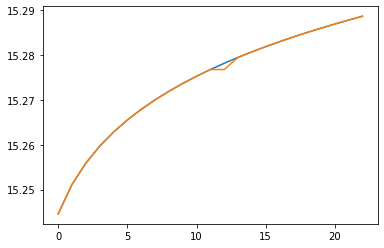

In [489]:
plt.plot(custom)
plt.plot(c128res[6])

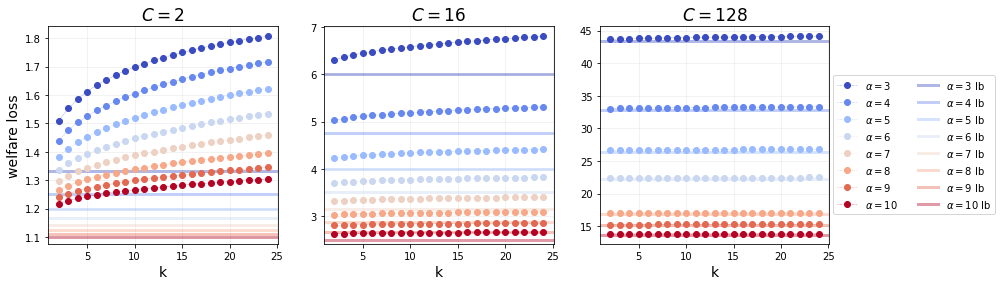

In [494]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

c = np.arange(1, len(alphas)+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

plot_handles = []
hline_handles = []
for i,a in enumerate(alphas):
    color = cmap.to_rgba(i+1)
    line, = axarr[0].plot(ns, c2res[i], linewidth=0.5, label=r'$\alpha=${:d}'.format(a), color=color,
                  linestyle='dotted', marker='o', fillstyle='full')
    hline = axarr[0].axhline((2+a-1)/a, alpha=0.4, color=color, linewidth=3,
                             label=r'$\alpha=${:d} lb'.format(a))
    plot_handles.append(line)
    hline_handles.append(hline)
    
    
    axarr[1].plot(ns, c16res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
    axarr[1].axhline((16+a-1)/a, alpha=0.4, color=color, linewidth=3)

    if i != 4:
        axarr[2].plot(ns, c128res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
        axarr[2].axhline((128+a-1)/a, alpha=0.4, color=color, linewidth=3)
    
    
handles = plot_handles + hline_handles
labels = [h.get_label() for h in handles]

for ax in axarr:
    ax.set_xlabel('k', size=14)
    ax.grid(alpha=0.2)

axarr[-1].legend(handles, labels, bbox_to_anchor=(1.37, 0.8), loc='upper center', ncol=2)

axarr[0].set_ylabel('welfare loss', size=14)
axarr[0].set_title(r'$C=2$', size=17)
axarr[1].set_title(r'$C=16$', size=17)
axarr[2].set_title(r'$C=128$', size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [42]:
a3res[2]

array([43.54167587,  1.02180144,  1.00484542,  1.00311307,  1.00273902,
        1.00609571,  1.0071116 ,  1.00812748,  1.00914334,  1.01015919,
        1.01117502,  1.01219083,  1.01320663,  1.01422241,  1.01523817,
        1.01625392,  1.01726965,  1.01828537,  1.01930107,  1.02031675,
        1.02133242,  1.02234807,  1.0233637 ,  1.02437932])

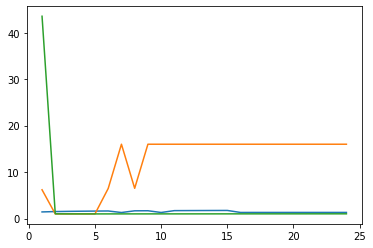

In [41]:
plt.plot(ns, a3res[0])
plt.plot(ns, a3res[1])
plt.plot(ns, a3res[2])

In [ ]:
a     = 3
Cs    = [2, 16, 128]
ns    = np.arange(1, 25)

a3res     = []
lbs       = []
initials  = [8, 16, 50]
for i,C in enumerate(Cs):
    temp = []
    lbs.append((C+a-1)/a)
    for n in tqdm(ns):
        costs = [1]
        costs.extend([C]*n)
        guess = [1]
        guess.extend([initials[i]]*n)
        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)
        temp.append(np.dot(costs, allos))
    a3res.append(temp)
a3res = np.array(a3res)
a3res.shape